First we need to install certain version of tensorflow, latest keras-cv
pycocotools is for the COCO metrics callback.
Since we tried many time of differen approach, some of these libraries we don'e necessarily need, but we'll leave it here.

In [1]:
# !apt-get update && apt-get -q install -y python3-opencv
!pip install -q  --upgrade  pycocotools wurlitzer keras-cv tensorflow==2.15.0
# plot losses and metrics curves
# Official APIs for the MS-COCO dataset, the backbone of our model 

Show if we successfully installed them, and show version

In [2]:
# !pip show pycocotools opencv-python

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
import pandas as pd
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm
from tensorflow import data as tf_data
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
# import cv2

2024-04-08 20:48:31.954105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 20:48:31.954245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 20:48:32.083956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


Agsin, show version infomation, since we have too many trouble dealing with version issue.
So we try to log each version we use.

In [4]:
!pip list | grep tensorflow
!pip list | grep keras
!pip list | grep cv

tensorflow                               2.15.0
tensorflow-cloud                         0.1.16
tensorflow-datasets                      4.9.4
tensorflow-decision-forests              1.8.1
tensorflow-estimator                     2.15.0
tensorflow-hub                           0.16.1
tensorflow-io                            0.35.0
tensorflow-io-gcs-filesystem             0.35.0
tensorflow-metadata                      0.14.0
tensorflow-probability                   0.23.0
tensorflow-serving-api                   2.14.1
tensorflow-text                          2.15.0
tensorflow-transform                     0.14.0
keras                                    2.15.0
keras-core                               0.1.7
keras-cv                                 0.8.2
keras-nlp                                0.8.2
keras-tuner                              1.4.6
tf_keras                                 2.15.1
keras-cv                                 0.8.2
opencv-contrib-python                    4.9.0.

In [5]:
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('TensorFlow version:', tf.__version__)
# print('Keras version:',keras.__version__)
print('KerasCV version:',keras_cv.__version__)
# print('cv2 version:',cv2.__version__)

Numpy version: 1.26.4
Pandas version: 2.2.1
TensorFlow version: 2.15.0
KerasCV version: 0.8.2


# 2. Dataset Loading and preprocessing

YOLOv8 need a input_shape of 640

In [6]:
input_shape = 640

In [7]:
# load anootations
df = pd.read_csv("/kaggle/input/tinylisa/combined.csv")
# df = df.sample(frac=1) # shuffle
df.head()

Filename Annotation tag  Upper left corner X  \
0  stop_1324866463.avi_image0.png           stop                  482   
1  stop_1324866463.avi_image1.png           stop                  491   
2  stop_1324866463.avi_image2.png           stop                  501   
3  stop_1324866463.avi_image3.png           stop                  515   
4  stop_1324866463.avi_image4.png           stop                  526   

   Upper left corner Y  Lower right corner X  Lower right corner Y  Occluded  \
0                  220                   503                   241         0   
1                  217                   514                   241         0   
2                  214                   526                   240         0   
3                  210                   542                   238         0   
4                  201                   555                   230         0   

   On another road        Origin file  Origin frame number  \
0                0  vid9/MVI_0121.MOV                  255   
1                0  vid9/MVI_0121.MOV                  260   
2                0  vid9/MVI_0121.MOV                  265   
3                0  vid9/MVI_0121.MOV                  270   
4                0  vid9/MVI_0121.MOV                  275   

          Origin track  Origin track frame number  
0  stop_1324866463.avi                          2  
1  stop_1324866463.avi                          7  
2  stop_1324866463.avi                         12  
3  stop_1324866463.avi                         17  
4  stop_1324866463.avi                         22

For faster training speed, we used a subset of LISA dataset--- get all the coloered images into one folder and combine the annotation csv together called combined.csv.
Subset LISA url:https://www.kaggle.com/datasets/mykkggle/tinylisa, we call it tiny LISA.
We did use the full LISA dataset, it is slower and the result metrics we get aren't necessarily better.

In [8]:
def full_path(x):
    path = os.path.join("/kaggle/input/tinylisa/tiny LISA/tiny LISA/", x)
    return path

df['Filename'] = df['Filename'].apply(full_path)
df.head(5)

Filename Annotation tag  \
0  /kaggle/input/tinylisa/tiny LISA/tiny LISA/sto...           stop   
1  /kaggle/input/tinylisa/tiny LISA/tiny LISA/sto...           stop   
2  /kaggle/input/tinylisa/tiny LISA/tiny LISA/sto...           stop   
3  /kaggle/input/tinylisa/tiny LISA/tiny LISA/sto...           stop   
4  /kaggle/input/tinylisa/tiny LISA/tiny LISA/sto...           stop   

   Upper left corner X  Upper left corner Y  Lower right corner X  \
0                  482                  220                   503   
1                  491                  217                   514   
2                  501                  214                   526   
3                  515                  210                   542   
4                  526                  201                   555   

   Lower right corner Y  Occluded  On another road        Origin file  \
0                   241         0                0  vid9/MVI_0121.MOV   
1                   241         0                0  vid9/MVI_0121.MOV   
2                   240         0                0  vid9/MVI_0121.MOV   
3                   238         0                0  vid9/MVI_0121.MOV   
4                   230         0                0  vid9/MVI_0121.MOV   

   Origin frame number         Origin track  Origin track frame number  
0                  255  stop_1324866463.avi                          2  
1                  260  stop_1324866463.avi                          7  
2                  265  stop_1324866463.avi                         12  
3                  270  stop_1324866463.avi                         17  
4                  275  stop_1324866463.avi                         22

Here, we tried a different approach to balance the data. Since some categories had only a few images, we attempted other methods initially. However, we later found that simply dropping these categories with fewer than 100 samples was more effective. This decision was crucial for our final results, as it improved our training speed and boosted our final precision and recall metrics. If there's anything more we could do, it would be further balancing the remaining categories.

In [9]:
category_counts = df['Annotation tag'].value_counts()

# Filter categories with counts less than 100
categories_to_keep = category_counts[category_counts >= 100].index

# Filter DataFrame to keep only rows with categories to keep
df = df[df['Annotation tag'].isin(categories_to_keep)]
category_counts = df['Annotation tag'].value_counts()
category_counts

Annotation tag
stop                  1060
signalAhead            392
pedestrianCrossing     244
speedLimit35           219
keepRight              175
speedLimitUrdbl        131
merge                  128
Name: count, dtype: int64

In [10]:
df["Filename"][0]

'/kaggle/input/tinylisa/tiny LISA/tiny LISA/stop_1324866463.avi_image0.png'

In [11]:
# encode Annotation tag
unique_classes = list(df["Annotation tag"].unique())
class_map = {k: v for k, v in zip(unique_classes, range(len(unique_classes)))}
class_map

{'stop': 0,
 'pedestrianCrossing': 1,
 'signalAhead': 2,
 'speedLimit35': 3,
 'keepRight': 4,
 'merge': 5,
 'speedLimitUrdbl': 6}

function to collect boounding boxes from the dataframe

In [12]:
# function to collect boounding boxes from the dataframe
def get_boxes(df):
    boxes = []
    
    for i in range(len(df)):
        x1 = df.iloc[i]["Upper left corner X"]
        y1 = df.iloc[i]["Upper left corner Y"]
        x2 = df.iloc[i]["Lower right corner X"]
        y2 = df.iloc[i]["Lower right corner Y"]
        
        box = [x1, y1, x2, y2]
        boxes.append(box)
        
    return boxes

Here we are using tf.ragged.constant to create ragged tensors from the bbox and classes lists. A ragged tensor is a type of tensor that can handle varying lengths of data along one or more dimensions. This is useful when dealing with data that has variable-length sequences, such as text or time series data.

In our case, the bbox and classes lists have different lengths for each image, depending on the number of objects in the image and the corresponding bounding boxes and classes. To handle this variability, ragged tensors are used instead of regular tensors.

Later, these ragged tensors are used to create a tf.data.Dataset using the from_tensor_slices method. This method creates a dataset from the input tensors by slicing them along the first dimension. By using ragged tensors, the dataset can handle varying lengths of data for each image and provide a flexible input pipeline for further processing.

In [13]:
# image_paths, classes, boxes slices
image_paths = list(df["Filename"])

classes = list(df["Annotation tag"])
classes = [class_map[x] for x in classes]
classes = [[x] for x in classes]

boxes = get_boxes(df)
boxes = [[x] for x in boxes]

boxes = tf.ragged.constant(boxes)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)
boxes,classes,image_paths

(<tf.RaggedTensor [[[482, 220, 503, 241]],
 
  [[491, 217, 514, 241]],
 
  [[501, 214, 526, 240]],
 
  ...,
 
  [[503, 152, 558, 206]],
 
  [[543, 227, 569, 255]],
 
  [[647, 193, 685, 231]]]>,
 <tf.RaggedTensor [[0],
  [0],
  [0],
  ...,
  [2],
  [6],
  [0]]>,
 <tf.Tensor: shape=(2349,), dtype=string, numpy=
 array([b'/kaggle/input/tinylisa/tiny LISA/tiny LISA/stop_1324866463.avi_image0.png',
        b'/kaggle/input/tinylisa/tiny LISA/tiny LISA/stop_1324866463.avi_image1.png',
        b'/kaggle/input/tinylisa/tiny LISA/tiny LISA/stop_1324866463.avi_image2.png',
        ...,
        b'/kaggle/input/tinylisa/tiny LISA/tiny LISA/signalAhead_1323815873.avi_image3.png',
        b'/kaggle/input/tinylisa/tiny LISA/tiny LISA/speedLimit_1323816193.avi_image0.png',
        b'/kaggle/input/tinylisa/tiny LISA/tiny LISA/stop_1323816242.avi_image3.png'],
       dtype=object)>)

The dictionary has two keys, 'boxes' and 'classes', each of which maps to a TensorFlow RaggedTensor or Tensor object. The 'boxes' Tensor has a shape of [batch, num_boxes, 4], where batch is the number of images in the batch and num_boxes is the maximum number of bounding boxes in any image. The 4 represents the four values needed to define a bounding box: xmin, ymin, xmax, ymax.

The 'classes' Tensor has a shape of [batch, num_boxes], where each element represents the class label for the corresponding bounding box in the 'boxes' Tensor. The num_boxes dimension may be ragged, which means that the number of boxes may vary across images in the batch.

In [14]:
# helper functions to load images with thier bbox for tf.data.Dataset
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Splitting data in training and validation data

In [15]:
# 10% to be used for validation and test
num_val = int(len(df) * 0.1)
num_val

234

In [16]:
# load dataset
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, boxes))

# split train / val
val_ds = data.take(num_val)
train_ds = data.skip(num_val)

One of the most challenging tasks when constructing object detection pipelines is data augmentation. It involves applying various transformations to the input images to increase the diversity of the training data and improve the model's ability to generalize. However, when working with object detection tasks, it becomes even more complex as these transformations need to be aware of the underlying bounding boxes and update them accordingly.

KerasCV provides native support for bounding box augmentation. KerasCV offers an extensive collection of data augmentation layers specifically designed to handle bounding boxes. These layers intelligently adjust the bounding box coordinates as the image is transformed, ensuring that the bounding boxes remain accurate and aligned with the augmented images.

By leveraging KerasCV's capabilities, we can conveniently integrate bounding box-friendly data augmentation into their object detection pipelines. By performing on-the-fly augmentation within a tf.data pipeline, the process becomes seamless and efficient, enabling better training and more accurate object detection results.

In [17]:
# augmentation pipeline for the training set
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.8, 1.25), bounding_box_format="xyxy",
        ),
    ]
)

In [18]:
BATCH_SIZE = 32
# load data
train_ds = train_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
# ragged batch
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# augment
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
# resize val images 
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy",
)

val_ds = val_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
# test_ds = test_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# test_ds = test_ds.shuffle(BATCH_SIZE * 4)
# test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# test_ds = test_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
# decode integer to class
class_mapping = {v: k for k, v in class_map.items()}
class_mapping

{0: 'stop',
 1: 'pedestrianCrossing',
 2: 'signalAhead',
 3: 'speedLimit35',
 4: 'keepRight',
 5: 'merge',
 6: 'speedLimitUrdbl'}

In [22]:
# helper function to visualize dataset
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

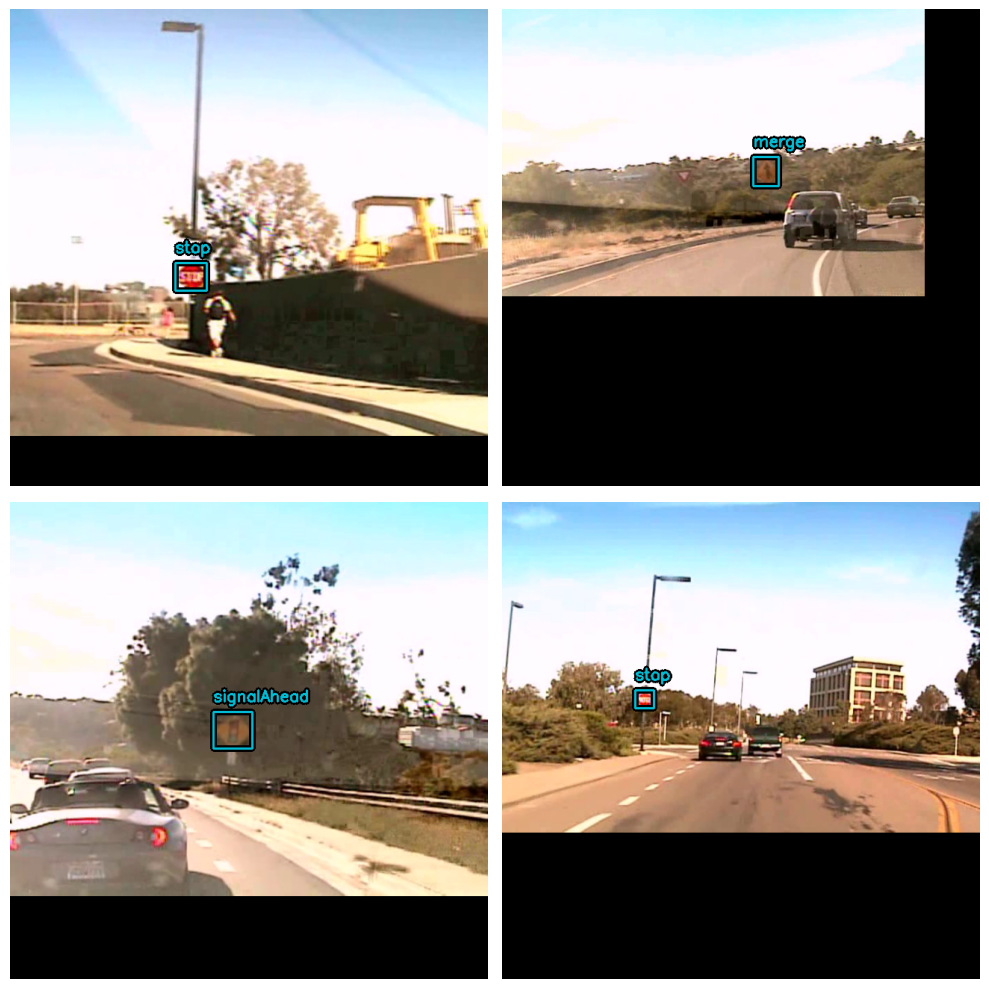

In [23]:
# visualize a sample from training set
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

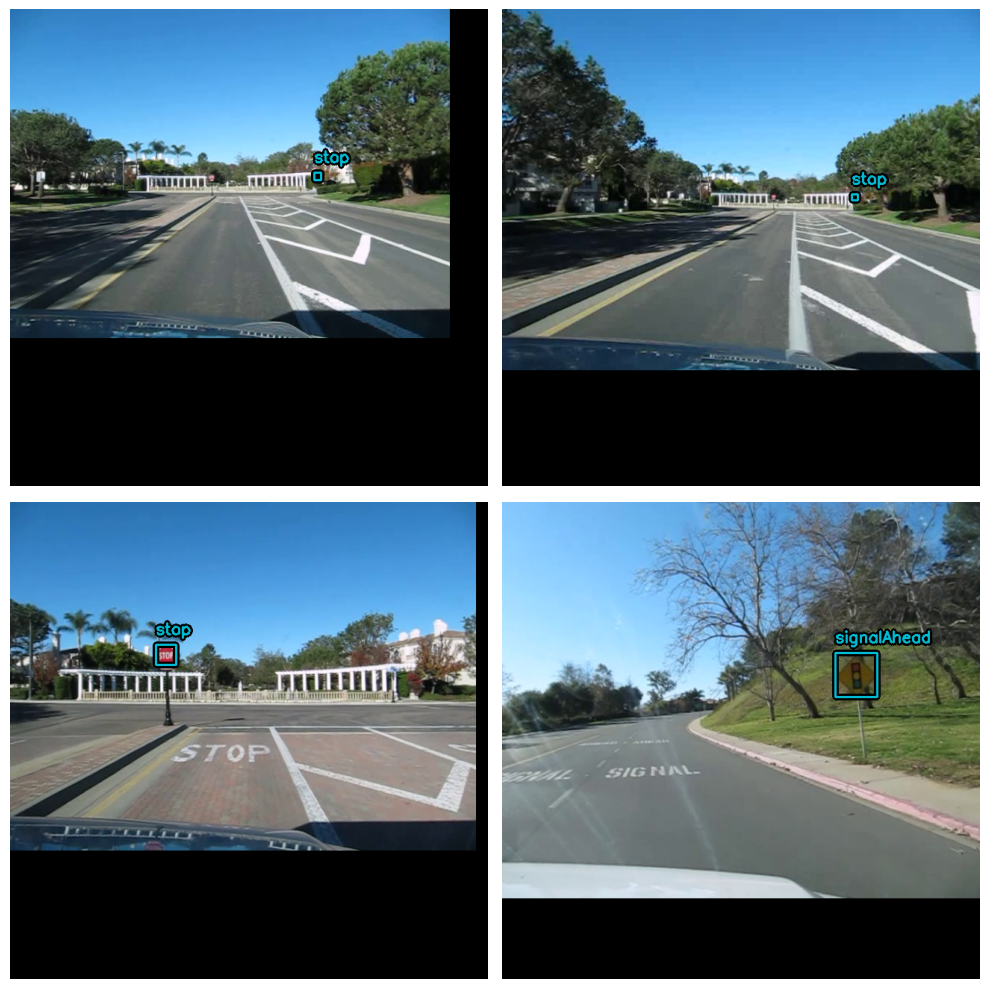

In [24]:
# visualize sample from val dataset
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be fed into the model.

In [25]:
def dict_to_tuple(inputs):
    """
    Function to convert the dictionary to a tuple
    :param inputs: Dictionary to convert
    :return: Tuple containing the image and bounding boxes
    """
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# 3. Model

We tried to use TPU since it's much faster, but it's kind of tricky to use it on kaggle so we give up

In [26]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

# # instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():

YOLOv8 is a cutting-edge YOLO model that is used for a variety of computer vision tasks, such as object detection, image classification, and instance segmentation. Ultralytics, the creators of YOLOv5, also developed YOLOv8, which incorporates many improvements and changes in architecture and developer experience compared to its predecessor. YOLOv9 is the latest model, but not yet available for use, so we use YOLOv8,the highly regarded model in the industry.

In [27]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco"  # We will use yolov8 extra small backbone with coco weights
)
# construct our mmodel
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)
# we will use adam optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm=10.0,
)



Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_xs_backbone_coco/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_xs_backbone_coco/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/yolov8/keras/yolo_v8_xs_backbone_coco/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


We tried to freese various layers, turned out the final metrics were worse than before freeze, so we keep not freeze them

In [28]:
##Freeze the first layers out of the 145
# for layer in yolo.layers:
#     layer.trainable=False
# compile the model


Compile the Model
Loss used for YOLOV8

Classification Loss: This loss function calculates the discrepancy between anticipated class probabilities and actual class probabilities. In this instance, binary_crossentropy, a prominent solution for binary classification issues, is Utilized. We Utilized binary crossentropy since each thing that is identified is either classed as belonging to or not belonging to a certain object class (such as a person, a car, etc.).

Box Loss: box_loss is the loss function used to measure the difference between the predicted bounding boxes and the ground truth. In this case, the Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding boxes but also considers the difference in aspect ratio, center distance, and box size. Together, these loss functions help optimize the model for object detection by minimizing the difference between the predicted and ground truth class probabilities and bounding boxes.

In [29]:
yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1277680   ['input_2[0][0]']             
                             64),                                                                 
                              'P4': (None, None, None,                                            
                             128),                                                                
                              'P5': (None, None, None,                                            
                             256)}                                                  

Another way to build the model, but we didn't use it, it is just different coding style

In [30]:
#  def build_model():
#     """
#     Builds the yolo model from the yolo_v8_s_coco backbone
#     :return: yolo model with the first 150 layers frozen
#     """
#     prediction_decoder = keras_cv.layers.NonMaxSuppression(
#         bounding_box_format="xyxy",
#         from_logits=True,
#         # Decrease the required threshold to make predictions get pruned out
#         iou_threshold=0.5,
#         # Tune confidence threshold for predictions to pass NMS
#         confidence_threshold=0.75,
#     )
    
#     # For transfer learning, we load the YOLOv8 weights trained on the COCO dataset
#     yolo = keras_cv.models.YOLOV8Detector.from_preset(
#         preset="yolo_v8_s_backbone_coco",    # A small YOLOV8 backbone with 5.09 million parameters. Ref: https://keras.io/api/keras_cv/models/backbones/yolo_v8/
#         num_classes=35,    # The number of neurons in the last layer
#         bounding_box_format="xyxy",
#         prediction_decoder=prediction_decoder,
#         fpn_depth=1,
#     )

#     optimizer = Adam(
#         learning_rate=0.001,
#         global_clipnorm=10.0,
#     )

#     # Freeze the first layers out of the 145
#     for layer in yolo.layers[:155]:
#         layer.trainable=False

#     yolo.compile(
#         optimizer=optimizer,
#         classification_loss="binary_crossentropy",
#         box_loss="ciou",
#     )    # User metrics is not supported yet for yolov8 so we have to use a callback for it
#     # This mean that we can just write e.g.  metrics=['acccuracy'], inside the compile call
    
#     return yolo

# yolo = build_model()

# COCO Metric Callback
BoxCOCOMetrics is actually deprecated, we did not use this

In [31]:
# BoxCOCOMetrics is actually deprecated, we did not use this
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            try:
                images, y_true = batch[0], batch[1]
            except KeyError:
            # Handle case where key is missing (e.g., log a warning)
                continue
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

We will be using PyCOCOCallback from KerasCV to evaluate the model and calculate the Map(Mean Average Precision) score, Recall and Precision. We also save our model when the mAP score improves.

In [32]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_ds, bounding_box_format="xyxy"
)

In [33]:
early_stopping_patience=5
early_stopping = EarlyStopping(
    patience=early_stopping_patience, 
    verbose=1
)
model_checkpoint = ModelCheckpoint(
    filepath='yolo-traffic-sign.keras',
    save_best_only=True,
    verbose=1
)

In [34]:
# train the model
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
#     callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
    callbacks=[coco_metrics_callback,early_stopping,model_checkpoint],
    shuffle=True,
)

Epoch 1/100


I0000 00:00:1712609410.679972     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 9s 169ms/steposs: 1909.8992 - box_loss: 3.9102 - class_lo
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.07s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


66/66 [==============================] - 137s 1s/step - loss: 1909.8992 - box_loss: 3.9102 - class_loss: 1905.9883 - val_loss: 4402.6943 - val_box_loss: 5.7151 - val_class_loss: 4396.9790 - val_AP: 0.0000e+00 - val_AP50: 0.0000e+00 - val_AP75: 0.0000e+00 - val_APs: 0.0000e+00 - val_APm: 0.0000e+00 - val_APl: -1.0000 - val_ARmax1: 0.0000e+00 - val_ARmax10: 0.0000e+00 - val_ARmax100: 0.0000e+00 - val_ARs: 0.0000e+00 - val_ARm: 0.0000e+00 - val_ARl: -1.0000
Epoch 2/100
7/7 [==============================] - 4s 597ms/steposs: 509.3436 - box_loss: 3.3475 - class_
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.00

We could futher fine tune our model by using smaller steps, but to save time, and our model is OK, so we skipped fine tunning step.

# 4. visualize predictions

In [35]:
# coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
#     bounding_box_format="xyxy",
#     evaluate_freq=1e9,
# )
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=10,
        rows=5,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [36]:
val_ds = val_ds.unbatch()
val_ds = val_ds.ragged_batch(num_val)

7/7 [==============================] - 4s 594ms/step


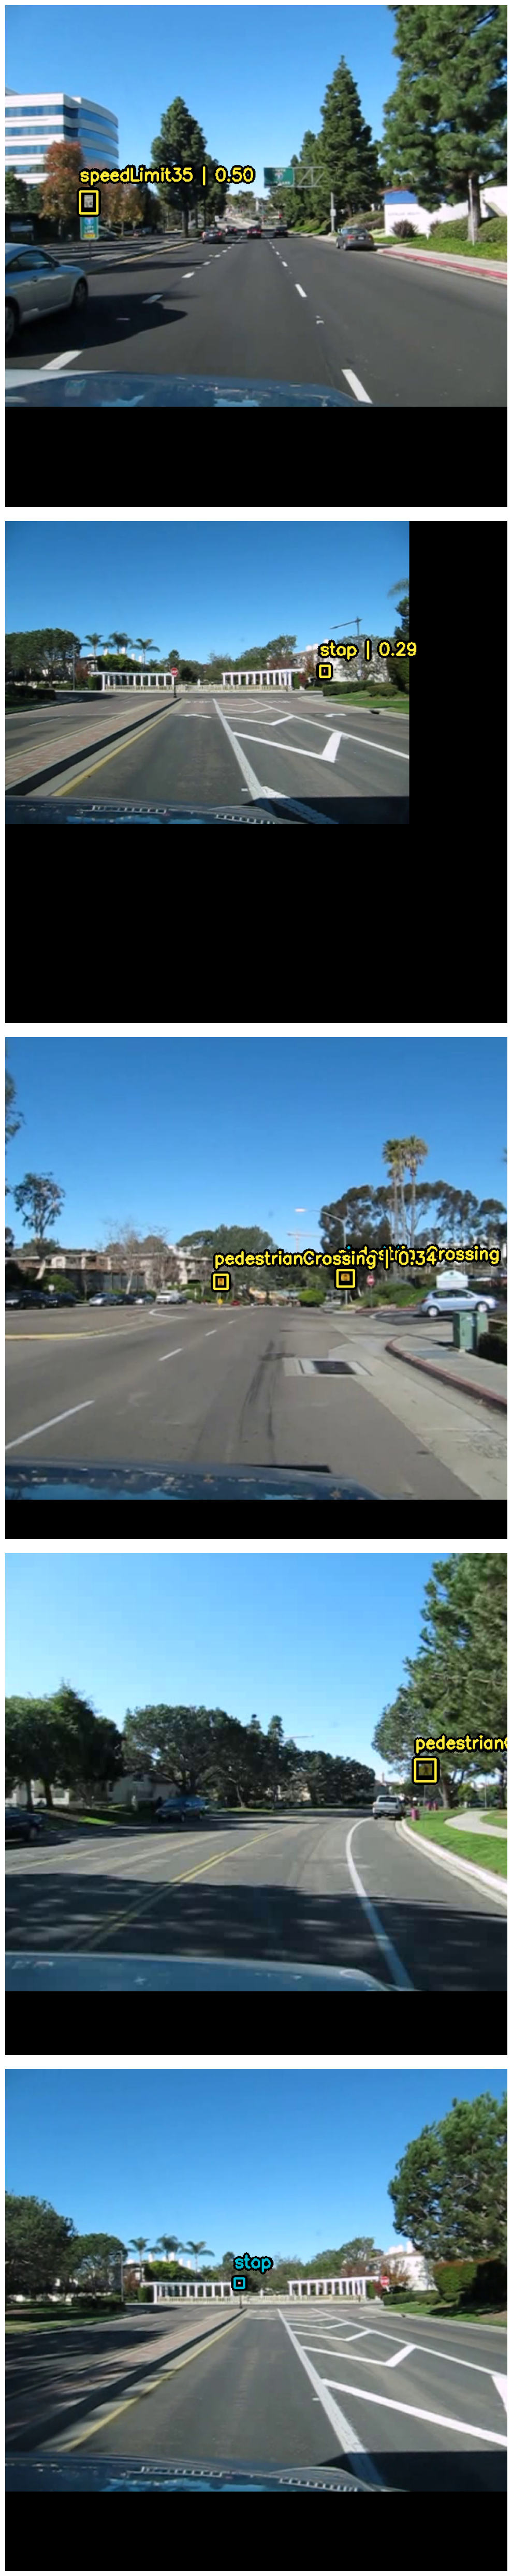

In [37]:
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

The result changes from each run/prediction, but still, it is much better than before we pre-process the dataset. That being said, we could do more to improve our metrics by (1) balance each categary better, or use a different dataset. (2)explore variants of model.